1282


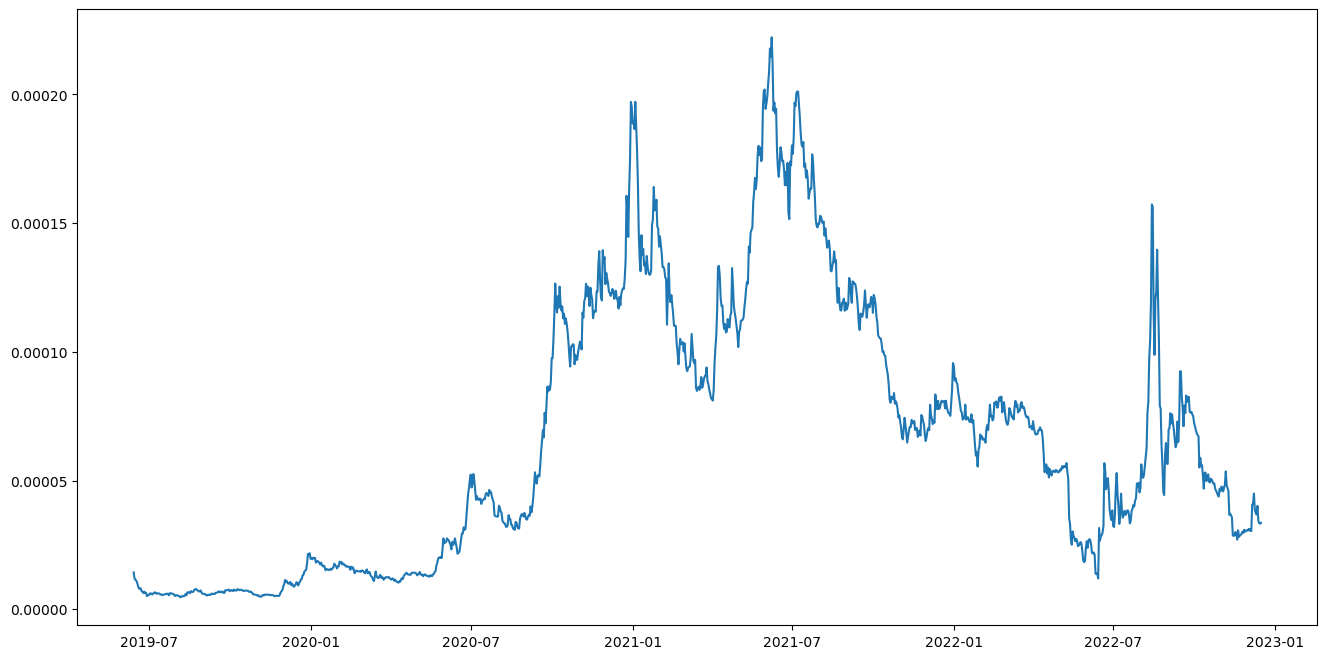

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data-master/csv/cel.csv')
# pd.read_json('path_to_json')
# Key name = Column name
print(len(df))

#setting index as date
df['time'] = pd.to_datetime(df.time,format='%Y-%m-%d')
df.index = df['time']

#sorting
df = df.sort_index(ascending=True, axis=0)

#plot
plt.figure(figsize=(16,8))
plt.plot(df['ReferenceRateBTC'], label='Close Price history')

In [8]:
from sklearn.preprocessing import MinMaxScaler

#creating a separate dataset
new_data = df[['time', 'ReferenceRateBTC']].copy()
dataset = new_data[['ReferenceRateBTC']].values

split = int(len(dataset) * 0.6)
print(split)

train = dataset[0:split,:]
valid = dataset[split:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

769


In [9]:
import numpy as np

x_train, y_train = [], []
for i in range(10, len(train)):
    x_train.append(scaled_data[i-10:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

x_test = []
for i in range(len(train), len(scaled_data)):
    x_test.append(scaled_data[i-10:i,0])
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=2)

Epoch 1/2
759/759 - 2s - loss: 0.0059 - 2s/epoch - 3ms/step
Epoch 2/2
759/759 - 1s - loss: 0.0025 - 1s/epoch - 2ms/step


In [11]:
closing_price = model.predict(x_test)
closing_price = scaler.inverse_transform(closing_price)
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

17/17 [==============================] - 0s 1ms/step


1.2309779190186496e-05

/var/folders/hk/g66fxbf571q9n016c0y4vfd40000gn/T/ipykernel_60870/2590299824.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


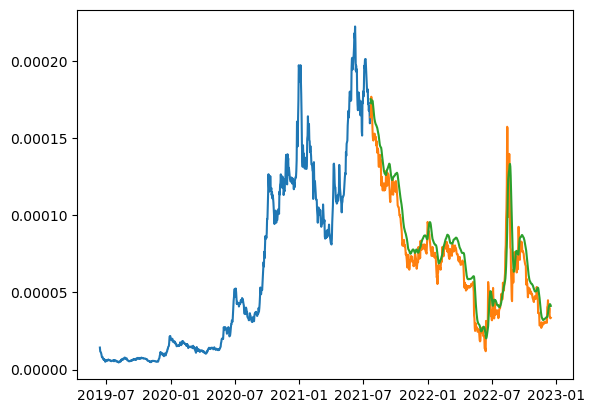

In [12]:
plt.figure()
train = new_data[:split]
valid = new_data[split:]
valid['Predictions'] = closing_price
plt.plot(train['ReferenceRateBTC'])
plt.plot(valid[['ReferenceRateBTC','Predictions']])